## Gun Violence in the Unites States

### 0. Introduzione
Spesso si sente parlare di sparatorie negli Stati Uniti con diversi morti. Il tema delle armi è scottante e spesso centrale in molti discorsi politici, dalla totale libertà dei Repubblicani alla timida voglia di cambiamento dei Democratici. 
Ma come sono distribuiti nei vari stati questi eventi? È presente una collocazione geografica precisa (est/ovest) o no?
Inoltre spesso si analizza anche la componente razziale di alcuni eventi. È presente una relazione tra il numero di morti e la composizione etnica della popolazione? 
Queste sono due delle domande a cui si cercherà di dare risposta.

### 1. I dataset
Entrambi i dataset trattati provengono dal CDC ([Center fo Desease Control and Prevention](https://www.cdc.gov/)):
- "Multiple Cause of Death, 1999-2020"
- "Single-Race Population Estimates 2010-2019"


Il dataset "Multiple Cause of Death, 1999-2020" contiene i dati riguardanti le morti per armi da fuoco negli anni 1999-2020 suddivisi per stato, genere e anno. Contiene i seguenti campi:

| Campo | Descrizone |
| ----------- | ----------- |
| State | Stato |
| Gender | Genere (Male, Female) |
| Year | Anno |
| Deaths | Numero di morti |

Il dataset "Single-Race Population Estimates 2010-2019" contiene i dati demografici dei singoli stati con enfasi sulle etnie della popolazione. Contiene i seguenti campi: 

| Campo | Descrizone |
| ----------- | ----------- |
| State | Stato |
| Gender | Genere (Male, Female) |
| Race | Razza: American Indian or Alaska Native, Black or Africa American, White, Asian |
| Year | Anno |
| Population | Numero di abitati |

Per il trattamento dei dati e delle successive operazioni di analisi saranno usate le seguenti liberie.
- pandas
- numpy
- seaborn

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

I dataset scaricati dal CDC sono in formato txt, quindi un primo passaggio sarà quello di convertirli in csv, successivamente si possono eliminare le clonne superflue. Il codice per questi passaggi è contenuto nel file "Gun-violence-in-US\Dataset\clean_data.py".
 
Carichiamo dunque i dataset ed manteniamo solo i dati relativi agli anni in comune, cioè 2010-2019.

In [2]:
# import dataset
dfGun = pd.read_csv('https://raw.githubusercontent.com/CriPiffe/Gun-violence-in-US/main/Dataset/Multiple%20Cause%20of%20Death%2C%201999-2020.csv')
dfDemo = pd.read_csv('https://raw.githubusercontent.com/CriPiffe/Gun-violence-in-US/main/Dataset/Single-Race%20Population%20Estimates%202010-2019.csv')

# rimozione dati 1999-2009 e 2020
dfGun = dfGun[(dfGun['Year']>2009) & (dfGun['Year']<2020)]

#dfGun.head()
#dfDemo.head()

### 2. Analisi geografica

Analizziamo la componente geografica.

In [3]:
dffDemo = dfDemo[['State','Gender','Year','Population']].groupby(by=['State','Gender','Year']).sum()

dffOnlyPopulation = pd.merge(dfGun,dffDemo, how='outer', on=['State','Gender','Year']).drop('Gender', axis=1)

dffOnlyPopulation.head()

,State,Year,Deaths,Population
0,Vermont,2010,10,312282
1,Massachusetts,2010,27,3322559
2,Georgia,2010,1020,4654470
3,Georgia,2010,199,4879114
4,Rhode Island,2010,0,531092


Un dato che può aiutare a capire la distribuzione geografica è il crude-rate, cioè il rapporto tra popolazione e morti per ogni anno (moltiplicato per una qualche costante per rendere i numeri più fruibili, nel nostro caso 1000).

In [4]:
crudeRate = [nDeaths/pop*1000 for (nDeaths, pop) in zip(dffOnlyPopulation['Deaths'], dffOnlyPopulation['Population'])]

dffOnlyPopulation.insert(loc=len(dffOnlyPopulation.columns), column='Crude Rate', value=crudeRate)

dffOnlyPopulation = dffOnlyPopulation.sort_values(by=['Crude Rate'], ascending=False)

#dffOnlyPopulation.to_csv('whithCrudeRate.csv', index=False)

Da una prima osservazione si nota come il crude rate vari da 0.42 a 0 e come le prime posizioni siano occupate da anni recenti (2015-2019). Per verificare questa ipotesi raggruppiamo per anno e facciamo la media di tutti i crude rate.

In [5]:
dfCrudeRateByYear = dffOnlyPopulation.drop(['State'], axis=1).groupby(by='Year').agg({'Deaths':'sum',
                                                                                       'Population':'sum',
                                                                                       'Crude Rate':'mean'})

dfCrudeRateByYear.head(10)

,Deaths,Population,Crude Rate
Year,,,
2010,31385,301604395,0.114768
2011,31952,303598215,0.114481
2012,33172,305628431,0.119061
2013,33222,307543270,0.119276
2014,33185,309597684,0.119085
2015,35822,311672283,0.130255
2016,38192,313717930,0.135565
2017,39291,315510757,0.140379
2018,39259,316972965,0.140390


L'ipotesi è confermata, i dati mostrano come con il passare degli anni la popolazione è aumentata di circa il 5%, il numero di morti per armi da fuoco è aumentato di circa il 20%. Il crude rate aumenta nel corso degli anni evidenziano un trend preoccupante per gli anni successivi. 

Passiamo ora ad analizzare i dati in base al luogo geografico, raggruppando quindi per stato ed ordinando per crude rate maggiore per verificare se vi è presente una distribuzione geografica rilevante.

In [13]:
dfMean = dffOnlyPopulation.drop('Year', axis=1).groupby(by='State', as_index=False).mean()

dfMean = dfMean.sort_values(by=['Crude Rate'], ascending=False)

dfMean.head()

,State,Deaths,Population,Crude Rate
1,Alaska,76.75,335432.20,0.222255
18,Louisiana,465.10,2278038.70,0.207326
24,Mississippi,289.05,1473177.15,0.200187
0,Alabama,465.85,2382097.45,0.199695
50,Wyoming,54.05,282913.50,0.188378


Si osserva come il crude rate più alto sia presente in Alaska, mentre al secondo, terzo e quarto posto troviamo Luisiana, Mississipi e Alabama che sono geograficamente situate nel sud-est del paese. Questo fenomeno è confermato saltando due posizioni e notando come anche Oklahoma Arkansas e Missouri abbiano un valore maggiore a 0.178, spostando il polo geografico verso il centro. Si delimita quindi una regione di stati confinanti con popolazione rilevante (più di un milione di abitanti) con un crude rate consistente ed elevato. 

Fenomeno simile si osserva negli stati più "diligenti", che si collogano nel nord-est del paese: Connecticut, New Jersey, New York e Rhode Island. 

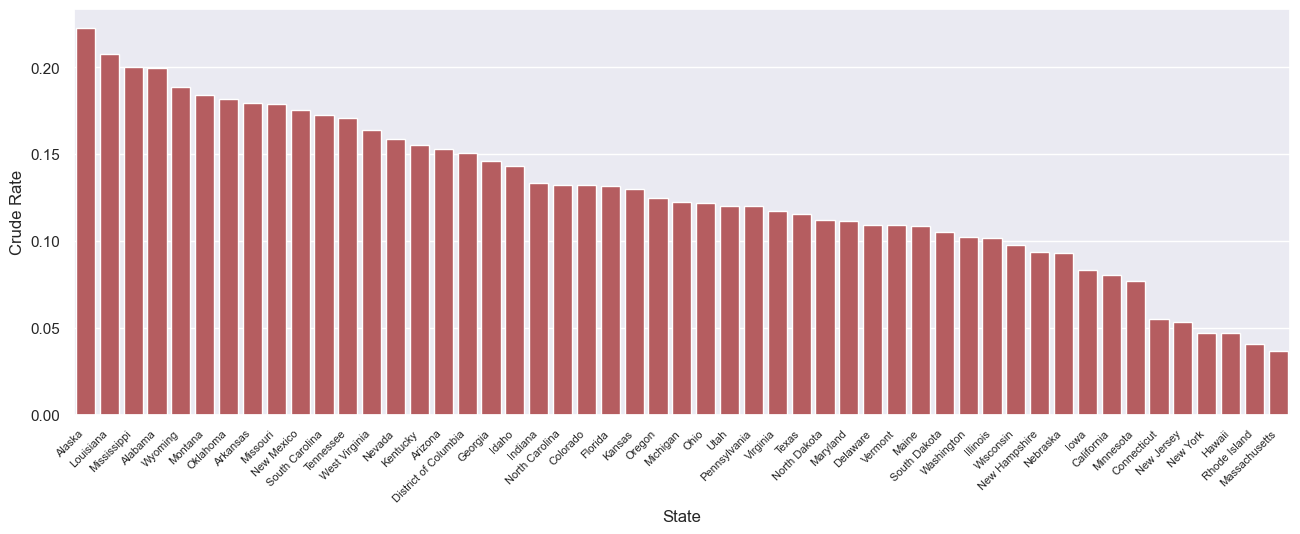

In [29]:
sns.set(rc={'figure.figsize':(15.7,5.27)})
plot =sns.barplot(dfMean, x='State', y='Crude Rate', color='r' )

plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right', size = 8);